In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import math

In [2]:
class EncoderLayer(nn.Module):
    """
    Represents one Encoder layer of the Transformer Encoder
    Refer Fig. 1 in https://arxiv.org/pdf/1706.03762.pdf
    NOTE: The layer normalization step has been moved to the input as per latest version of T2T
    """
    def __init__(self, hidden_size, total_key_depth, total_value_depth, filter_size, num_heads,
                 bias_mask=None, layer_dropout=0.0, attention_dropout=0.0, relu_dropout=0.0):
        """
        Parameters:
            hidden_size: Hidden size
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            layer_dropout: Dropout for this layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
        """
        
        super(EncoderLayer, self).__init__()
        
        self.multi_head_attention = MultiHeadAttention(hidden_size, total_key_depth, total_value_depth, 
                                                       hidden_size, num_heads, bias_mask, attention_dropout)
        
        self.positionwise_feed_forward = PositionwiseFeedForward(hidden_size, filter_size, hidden_size,
                                                                 layer_config='cc', padding = 'both', 
                                                                 dropout=relu_dropout)
        self.dropout = nn.Dropout(layer_dropout)
        self.layer_norm_mha = LayerNorm(hidden_size)
        self.layer_norm_ffn = LayerNorm(hidden_size)
        
    def forward(self, inputs):
        x = inputs
        
        # Layer Normalization
        x_norm = self.layer_norm_mha(x)
        
        # Multi-head attention
        y = self.multi_head_attention(x_norm, x_norm, x_norm)
        
        # Dropout and residual
        x = self.dropout(x + y)
        
        # Layer Normalization
        x_norm = self.layer_norm_ffn(x)
        
        # Positionwise Feedforward
        y = self.positionwise_feed_forward(x_norm)
        
        # Dropout and residual
        y = self.dropout(x + y)
        
        return y

In [3]:
class MultiHeadAttention(nn.Module):
    """
    Multi-head attention as per https://arxiv.org/pdf/1706.03762.pdf
    Refer Figure 2
    """
    def __init__(self, input_depth, total_key_depth, total_value_depth, output_depth, 
                 num_heads, bias_mask=None, dropout=0.0):
        """
        Parameters:
            input_depth: Size of last dimension of input
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            num_heads: Number of attention heads
            bias_mask: Masking tensor to prevent connections to future elements
            dropout: Dropout probability (Should be non-zero only during training)
        """
        super(MultiHeadAttention, self).__init__()
        # Checks borrowed from 
        # https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/layers/common_attention.py
        if total_key_depth % num_heads != 0:
            raise ValueError("Key depth (%d) must be divisible by the number of "
                             "attention heads (%d)." % (total_key_depth, num_heads))
        if total_value_depth % num_heads != 0:
            raise ValueError("Value depth (%d) must be divisible by the number of "
                             "attention heads (%d)." % (total_value_depth, num_heads))
            
        self.num_heads = num_heads
        self.query_scale = (total_key_depth//num_heads)**-0.5
        self.bias_mask = bias_mask
        
        # Key and query depth will be same
        self.query_linear = nn.Linear(input_depth, total_key_depth, bias=False)
        self.key_linear = nn.Linear(input_depth, total_key_depth, bias=False)
        self.value_linear = nn.Linear(input_depth, total_value_depth, bias=False)
        self.output_linear = nn.Linear(total_value_depth, output_depth, bias=False)
        
        self.dropout = nn.Dropout(dropout)
    
    def _split_heads(self, x):
        """
        Split x such to add an extra num_heads dimension
        Input:
            x: a Tensor with shape [batch_size, seq_length, depth]
        Returns:
            A Tensor with shape [batch_size, num_heads, seq_length, depth/num_heads]
        """
        if len(x.shape) != 3:
            raise ValueError("x must have rank 3")
        shape = x.shape
        return x.view(shape[0], shape[1], self.num_heads, shape[2]//self.num_heads).permute(0, 2, 1, 3)
    
    def _merge_heads(self, x):
        """
        Merge the extra num_heads into the last dimension
        Input:
            x: a Tensor with shape [batch_size, num_heads, seq_length, depth/num_heads]
        Returns:
            A Tensor with shape [batch_size, seq_length, depth]
        """
        if len(x.shape) != 4:
            raise ValueError("x must have rank 4")
        shape = x.shape
        return x.permute(0, 2, 1, 3).contiguous().view(shape[0], shape[2], shape[3]*self.num_heads)
        
    def forward(self, queries, keys, values, src_mask=None):
        
        # Do a linear for each component
        queries = self.query_linear(queries)
        keys = self.key_linear(keys)
        values = self.value_linear(values)
        
        # Split into multiple heads
        queries = self._split_heads(queries)
        keys = self._split_heads(keys)
        values = self._split_heads(values)
        
        # Scale queries
        queries *= self.query_scale
        
        # Combine queries and keys
        logits = torch.matmul(queries, keys.permute(0, 1, 3, 2))
        

        if src_mask is not None:
            logits = logits.masked_fill(src_mask, -np.inf)
            
        # Add bias to mask future values
        if self.bias_mask is not None:
            logits += self.bias_mask[:, :, :logits.shape[-2], :logits.shape[-1]].type_as(logits.data)
        
        # Convert to probabilites
        weights = nn.functional.softmax(logits, dim=-1)
        
        # Dropout
        weights = self.dropout(weights)
        
        # Combine with values to get context
        contexts = torch.matmul(weights, values)
        
        # Merge heads
        contexts = self._merge_heads(contexts)
        #contexts = torch.tanh(contexts)
        
        # Linear to get output
        outputs = self.output_linear(contexts)
        
        return outputs

In [4]:
class Conv(nn.Module):
    """
    Convenience class that does padding and convolution for inputs in the format
    [batch_size, sequence length, hidden size]
    """
    def __init__(self, input_size, output_size, kernel_size, pad_type):
        """
        Parameters:
            input_size: Input feature size
            output_size: Output feature size
            kernel_size: Kernel width
            pad_type: left -> pad on the left side (to mask future data), 
                      both -> pad on both sides
        """
        super(Conv, self).__init__()
        padding = (kernel_size - 1, 0) if pad_type == 'left' else (kernel_size//2, (kernel_size - 1)//2)
        self.pad = nn.ConstantPad1d(padding, 0)
        self.conv = nn.Conv1d(input_size, output_size, kernel_size=kernel_size, padding=0)

    def forward(self, inputs):
        inputs = self.pad(inputs.permute(0, 2, 1))
        outputs = self.conv(inputs).permute(0, 2, 1)

        return outputs

In [5]:
class PositionwiseFeedForward(nn.Module):
    """
    Does a Linear + RELU + Linear on each of the timesteps
    """
    def __init__(self, input_depth, filter_size, output_depth, layer_config='ll', padding='left', dropout=0.0):
        """
        Parameters:
            input_depth: Size of last dimension of input
            filter_size: Hidden size of the middle layer
            output_depth: Size last dimension of the final output
            layer_config: ll -> linear + ReLU + linear
                          cc -> conv + ReLU + conv etc.
            padding: left -> pad on the left side (to mask future data), 
                     both -> pad on both sides
            dropout: Dropout probability (Should be non-zero only during training)
        """
        super(PositionwiseFeedForward, self).__init__()
        
        layers = []
        sizes = ([(input_depth, filter_size)] + 
                 [(filter_size, filter_size)]*(len(layer_config)-2) + 
                 [(filter_size, output_depth)])

        for lc, s in zip(list(layer_config), sizes):
            if lc == 'l':
                layers.append(nn.Linear(*s))
            elif lc == 'c':
                layers.append(Conv(*s, kernel_size=3, pad_type=padding))
            else:
                raise ValueError("Unknown layer type {}".format(lc))

        self.layers = nn.ModuleList(layers)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inputs):
        x = inputs
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers):
                x = self.relu(x)
                x = self.dropout(x)

        return x


In [6]:
class LayerNorm(nn.Module):
    # Borrowed from jekbradbury
    # https://github.com/pytorch/pytorch/issues/1959
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


In [7]:
def _gen_bias_mask(max_length):
    """
    Generates bias values (-Inf) to mask future timesteps during attention
    """
    np_mask = np.triu(np.full([max_length, max_length], -np.inf), 1)
    torch_mask = torch.from_numpy(np_mask).type(torch.FloatTensor)
    
    return torch_mask.unsqueeze(0).unsqueeze(1)

In [8]:
def _gen_timing_signal(length, channels, min_timescale=1.0, max_timescale=1.0e4):
    """
    Generates a [1, length, channels] timing signal consisting of sinusoids
    Adapted from:
    https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/layers/common_attention.py
    """
    position = np.arange(length)
    num_timescales = channels // 2
    log_timescale_increment = ( math.log(float(max_timescale) / float(min_timescale)) / (float(num_timescales) - 1))
    inv_timescales = min_timescale * np.exp(np.arange(num_timescales).astype(np.float) * -log_timescale_increment)
    scaled_time = np.expand_dims(position, 1) * np.expand_dims(inv_timescales, 0)

    signal = np.concatenate([np.sin(scaled_time), np.cos(scaled_time)], axis=1)
    signal = np.pad(signal, [[0, 0], [0, channels % 2]], 
                    'constant', constant_values=[0.0, 0.0])
    signal =  signal.reshape([1, length, channels])

    return torch.from_numpy(signal).type(torch.FloatTensor)

In [9]:
class Encoder(nn.Module):
    """
    A Transformer Encoder module. 
    Inputs should be in the shape [batch_size, length, hidden_size]
    Outputs will have the shape [batch_size, length, hidden_size]
    Refer Fig.1 in https://arxiv.org/pdf/1706.03762.pdf
    """
    def __init__(self, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=100, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0, use_mask=False, act=True):
        """
        Parameters:
            hidden_size: Hidden size
            num_layers: Total layers in the Encoder
            num_heads: Number of attention heads
            total_key_depth: Size of last dimension of keys. Must be divisible by num_head
            total_value_depth: Size of last dimension of values. Must be divisible by num_head
            output_depth: Size last dimension of the final output
            filter_size: Hidden size of the middle layer in FFN
            max_length: Max sequence length (required for timing signal)
            input_dropout: Dropout just after embedding
            layer_dropout: Dropout for each layer
            attention_dropout: Dropout probability after attention (Should be non-zero only during training)
            relu_dropout: Dropout probability after relu in FFN (Should be non-zero only during training)
            use_mask: Set to True to turn on future value masking
        """
        
        super(Encoder, self).__init__()
        
        self.timing_signal = _gen_timing_signal(max_length, hidden_size)
        ## for t
        self.position_signal = _gen_timing_signal(num_layers, hidden_size)

        self.num_layers = num_layers
        self.act = act
        params =(hidden_size, 
                 total_key_depth or hidden_size,
                 total_value_depth or hidden_size,
                 filter_size, 
                 num_heads, 
                 _gen_bias_mask(max_length) if use_mask else None,
                 layer_dropout, 
                 attention_dropout, 
                 relu_dropout)

        self.enc = EncoderLayer(*params)
        
        self.layer_norm = LayerNorm(hidden_size)
        self.input_dropout = nn.Dropout(input_dropout)
        if(self.act):
            self.act_fn = ACT_basic(hidden_size)

    def forward(self, inputs):

        #Add input dropout
        x = self.input_dropout(inputs)

        if(self.act):
            x, (remainders,n_updates) = self.act_fn(x, inputs, self.enc, self.timing_signal, self.position_signal, self.num_layers)
            return x, (remainders,n_updates)
        else:
            for l in range(self.num_layers):
                x += self.timing_signal[:, :inputs.shape[1], :].type_as(inputs.data)
                x += self.position_signal[:, l, :].unsqueeze(1).repeat(1,inputs.shape[1],1).type_as(inputs.data)
                x = self.enc(x)
            return x, None

In [10]:
class ACT_basic(nn.Module):
    def __init__(self,hidden_size):
        super(ACT_basic, self).__init__()
        self.sigma = nn.Sigmoid()
        self.p = nn.Linear(hidden_size,1)  
        self.p.bias.data.fill_(1) 
        self.threshold = 1 - 0.1

    def forward(self, state, inputs, fn, time_enc, pos_enc, max_hop, encoder_output=None):
        # init_hdd
        ## [B, S]
        halting_probability = torch.zeros(inputs.shape[0],inputs.shape[1])
        ## [B, S
        remainders = torch.zeros(inputs.shape[0],inputs.shape[1])
        ## [B, S]
        n_updates = torch.zeros(inputs.shape[0],inputs.shape[1])
        ## [B, S, HDD]
        previous_state = torch.zeros_like(inputs)
        step = 0
        # for l in range(self.num_layers):
        while( ((halting_probability<self.threshold) & (n_updates < max_hop)).byte().any()):
            # Add timing signal
            state = state + time_enc[:, :inputs.shape[1], :].type_as(inputs.data)
            state = state + pos_enc[:, step, :].unsqueeze(1).repeat(1,inputs.shape[1],1).type_as(inputs.data)

            p = self.sigma(self.p(state)).squeeze(-1)
            # Mask for inputs which have not halted yet
            still_running = (halting_probability < 1.0).float()

            # Mask of inputs which halted at this step
            new_halted = (halting_probability + p * still_running > self.threshold).float() * still_running

            # Mask of inputs which haven't halted, and didn't halt this step
            still_running = (halting_probability + p * still_running <= self.threshold).float() * still_running

            # Add the halting probability for this step to the halting
            # probabilities for those input which haven't halted yet
            halting_probability = halting_probability + p * still_running

            # Compute remainders for the inputs which halted at this step
            remainders = remainders + new_halted * (1 - halting_probability)

            # Add the remainders to those inputs which halted at this step
            halting_probability = halting_probability + new_halted * remainders

            # Increment n_updates for all inputs which are still running
            n_updates = n_updates + still_running + new_halted

            # Compute the weight to be applied to the new state and output
            # 0 when the input has already halted
            # p when the input hasn't halted yet
            # the remainders when it halted this step
            update_weights = p * still_running + new_halted * remainders

            if(encoder_output):
                state, _ = fn((state,encoder_output))
            else:
                # apply transformation on the state
                state = fn(state)

            # update running part in the weighted state and keep the rest
            previous_state = ((state * update_weights.unsqueeze(-1)) + (previous_state * (1 - update_weights.unsqueeze(-1))))
            ## previous_state is actually the new_state at end of hte loop 
            ## to save a line I assigned to previous_state so in the next 
            ## iteration is correct. Notice that indeed we return previous_state
            step+=1
        return previous_state, (remainders,n_updates)

In [11]:
class BabiUTransformer(nn.Module):
    """
    A Transformer Module For BabI data. 
    Inputs should be in the shape story: [batch_size, memory_size, story_len ]
                                  query: [batch_size, 1, story_len]
    Outputs will have the shape [batch_size, ]
    """
    def __init__(self, output_size, hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                 filter_size, max_length=71, input_dropout=0.0, layer_dropout=0.0, 
                 attention_dropout=0.0, relu_dropout=0.0, use_mask=False, act=True ):
        super(BabiUTransformer, self).__init__()

        self.transformer_enc = Encoder(hidden_size, num_layers, num_heads, total_key_depth, total_value_depth,
                                filter_size, max_length=71, input_dropout=input_dropout, layer_dropout=layer_dropout, 
                                attention_dropout=attention_dropout, relu_dropout=relu_dropout, use_mask=False, act=act)

        self.W = nn.Linear(hidden_size, output_size)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, story):

        logit, act = self.transformer_enc(story)
        
        a_hat = self.W(torch.sum(logit,dim=1)/logit.size(1)) ## reduce mean

        return a_hat, self.softmax(a_hat), act


In [12]:
output_size = 1
hidden_size=22
total_key_depth=22
total_value_depth=22
filter_size=64
num_layers=2
num_heads=2
device = torch.device("cpu")

In [13]:
model = BabiUTransformer(
    output_size, 
    hidden_size, 
    num_layers, 
    num_heads, 
    total_key_depth, 
    total_value_depth,
    filter_size
).to(device)

<ipython-input-8-e41c5c72579e>:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  inv_timescales = min_timescale * np.exp(np.arange(num_timescales).astype(np.float) * -log_timescale_increment)


In [14]:
story = torch.rand(5,20,22).to(device)

In [15]:
output, softmax_output, act = model(story)
print(output.shape)
print(output)

torch.Size([5, 1])
tensor([[0.0726],
        [0.0048],
        [0.0379],
        [0.0335],
        [0.0332]], grad_fn=<AddmmBackward0>)


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [17]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [18]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [19]:
df_for_training=df[feature_names].astype(float)

In [20]:
df_for_training.shape

(11524, 22)

In [21]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [22]:
trainX=[]
trainY=[]

In [23]:
n_future=1
n_past=20

In [24]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [25]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [26]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [27]:
def random_shuffle(data,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data,label

In [28]:
data,label=random_shuffle(trainX,trainY)

In [29]:
def standardization(data):
    mu = np.min(data)
    sigma = np.max(data)-np.min(data)
    return (data - mu) / sigma

In [30]:
for j in range(0,data.shape[2]):
    data[:,:,j]=standardization(data[:,:,j])

In [31]:
label=standardization(label)

In [32]:
# Create a DataLoader for the training data
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data, label)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
criterion = nn.L1Loss()

In [34]:
device = torch.device("cpu")

In [35]:
for epoch in range(1000):
    
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        #import pdb;pdb.set_trace()
        data = data.to(device=device)
        targets = targets.to(device=device)
        output, softmax_output, act = model(data)
       
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())

    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

D:\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.25786635279655457
Epoch: 1 Loss: 0.12551811337471008
Epoch: 2 Loss: 0.1064811646938324
Epoch: 3 Loss: 0.0727544054389
Epoch: 4 Loss: 0.05100715532898903
Epoch: 5 Loss: 0.05110325664281845
Epoch: 6 Loss: 0.07381509989500046
Epoch: 7 Loss: 0.06868556886911392
Epoch: 8 Loss: 0.052541982382535934
Epoch: 9 Loss: 0.06642908602952957
Epoch: 10 Loss: 0.03230302035808563
Epoch: 11 Loss: 0.04938080534338951
Epoch: 12 Loss: 0.08736937493085861
Epoch: 13 Loss: 0.03337910771369934
Epoch: 14 Loss: 0.03751332312822342
Epoch: 15 Loss: 0.042806096374988556
Epoch: 16 Loss: 0.08911334723234177
Epoch: 17 Loss: 0.03381674364209175
Epoch: 18 Loss: 0.03472725301980972
Epoch: 19 Loss: 0.05138213187456131
Epoch: 20 Loss: 0.04409829154610634
Epoch: 21 Loss: 0.05779516324400902
Epoch: 22 Loss: 0.039388880133628845
Epoch: 23 Loss: 0.046180859208106995
Epoch: 24 Loss: 0.052253421396017075
Epoch: 25 Loss: 0.031439781188964844
Epoch: 26 Loss: 0.0656055137515068
Epoch: 27 Loss: 0.05433525890111923
Ep

Epoch: 223 Loss: 0.018829742446541786
Epoch: 224 Loss: 0.020204715430736542
Epoch: 225 Loss: 0.019081128761172295
Epoch: 226 Loss: 0.018682781606912613
Epoch: 227 Loss: 0.01892784796655178
Epoch: 228 Loss: 0.020360257476568222
Epoch: 229 Loss: 0.019096603617072105
Epoch: 230 Loss: 0.02043849788606167
Epoch: 231 Loss: 0.022387702018022537
Epoch: 232 Loss: 0.01993478089570999
Epoch: 233 Loss: 0.023249007761478424
Epoch: 234 Loss: 0.020613357424736023
Epoch: 235 Loss: 0.019628912210464478
Epoch: 236 Loss: 0.02036847546696663
Epoch: 237 Loss: 0.021539881825447083
Epoch: 238 Loss: 0.020518505945801735
Epoch: 239 Loss: 0.023512233048677444
Epoch: 240 Loss: 0.02041323482990265
Epoch: 241 Loss: 0.020760882645845413
Epoch: 242 Loss: 0.018904127180576324
Epoch: 243 Loss: 0.01913207396864891
Epoch: 244 Loss: 0.019152436405420303
Epoch: 245 Loss: 0.02032848820090294
Epoch: 246 Loss: 0.020218420773744583
Epoch: 247 Loss: 0.019206034019589424
Epoch: 248 Loss: 0.021559083834290504
Epoch: 249 Loss: 0.

Epoch: 441 Loss: 0.014563042670488358
Epoch: 442 Loss: 0.01565145142376423
Epoch: 443 Loss: 0.011974364519119263
Epoch: 444 Loss: 0.014312883839011192
Epoch: 445 Loss: 0.016951514407992363
Epoch: 446 Loss: 0.014030839316546917
Epoch: 447 Loss: 0.012837165035307407
Epoch: 448 Loss: 0.011237448081374168
Epoch: 449 Loss: 0.01569397747516632
Epoch: 450 Loss: 0.012460710480809212
Epoch: 451 Loss: 0.011633065529167652
Epoch: 452 Loss: 0.01604989543557167
Epoch: 453 Loss: 0.0122766625136137
Epoch: 454 Loss: 0.016449272632598877
Epoch: 455 Loss: 0.015780052170157433
Epoch: 456 Loss: 0.012249063700437546
Epoch: 457 Loss: 0.012555118650197983
Epoch: 458 Loss: 0.012648663483560085
Epoch: 459 Loss: 0.017187979072332382
Epoch: 460 Loss: 0.015584133565425873
Epoch: 461 Loss: 0.011290636844933033
Epoch: 462 Loss: 0.013612320646643639
Epoch: 463 Loss: 0.01456398144364357
Epoch: 464 Loss: 0.011480636894702911
Epoch: 465 Loss: 0.011482956819236279
Epoch: 466 Loss: 0.013208967633545399
Epoch: 467 Loss: 0

Epoch: 658 Loss: 0.014157835394144058
Epoch: 659 Loss: 0.011560152284801006
Epoch: 660 Loss: 0.011459169909358025
Epoch: 661 Loss: 0.01262609288096428
Epoch: 662 Loss: 0.011960884556174278
Epoch: 663 Loss: 0.013202395290136337
Epoch: 664 Loss: 0.012631820514798164
Epoch: 665 Loss: 0.011175567284226418
Epoch: 666 Loss: 0.01364261656999588
Epoch: 667 Loss: 0.012313596904277802
Epoch: 668 Loss: 0.012657631188631058
Epoch: 669 Loss: 0.010448606684803963
Epoch: 670 Loss: 0.01146170124411583
Epoch: 671 Loss: 0.011367347091436386
Epoch: 672 Loss: 0.013692023232579231
Epoch: 673 Loss: 0.012138774618506432
Epoch: 674 Loss: 0.01187075860798359
Epoch: 675 Loss: 0.012155627831816673
Epoch: 676 Loss: 0.011462854221463203
Epoch: 677 Loss: 0.012020206078886986
Epoch: 678 Loss: 0.01436919067054987
Epoch: 679 Loss: 0.013037700206041336
Epoch: 680 Loss: 0.01110045239329338
Epoch: 681 Loss: 0.01300148293375969
Epoch: 682 Loss: 0.012043502181768417
Epoch: 683 Loss: 0.011413675732910633
Epoch: 684 Loss: 0.

Epoch: 875 Loss: 0.010350645519793034
Epoch: 876 Loss: 0.010742509737610817
Epoch: 877 Loss: 0.010426703840494156
Epoch: 878 Loss: 0.011743234470486641
Epoch: 879 Loss: 0.010869939811527729
Epoch: 880 Loss: 0.011840300634503365
Epoch: 881 Loss: 0.009600427001714706
Epoch: 882 Loss: 0.011507749557495117
Epoch: 883 Loss: 0.011611600406467915
Epoch: 884 Loss: 0.012236550450325012
Epoch: 885 Loss: 0.010642576962709427
Epoch: 886 Loss: 0.011535418219864368
Epoch: 887 Loss: 0.00876815989613533
Epoch: 888 Loss: 0.008167105726897717
Epoch: 889 Loss: 0.010276911780238152
Epoch: 890 Loss: 0.009818995371460915
Epoch: 891 Loss: 0.018279187381267548
Epoch: 892 Loss: 0.014232592657208443
Epoch: 893 Loss: 0.009916160255670547
Epoch: 894 Loss: 0.016186825931072235
Epoch: 895 Loss: 0.023665666580200195
Epoch: 896 Loss: 0.01049988716840744
Epoch: 897 Loss: 0.017351187765598297
Epoch: 898 Loss: 0.0064018117263913155
Epoch: 899 Loss: 0.02041306532919407
Epoch: 900 Loss: 0.011727387085556984
Epoch: 901 Los

In [36]:
trainX_copy_=trainX_copy
trainY_copy_=trainY_copy

In [37]:
for j in range(0,trainX_copy_.shape[2]):
    trainX_copy_[:,:,j]=standardization(trainX_copy_[:,:,j])

In [38]:
trainY_copy_=standardization(trainY_copy_)

In [39]:
test_data = torch.from_numpy(trainX_copy_).float()
test_label = torch.from_numpy(trainY_copy_).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [40]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    output, softmax_output, act=model(data)
    predictions+=output.tolist()

In [41]:
predictions = np.array(predictions)

In [42]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

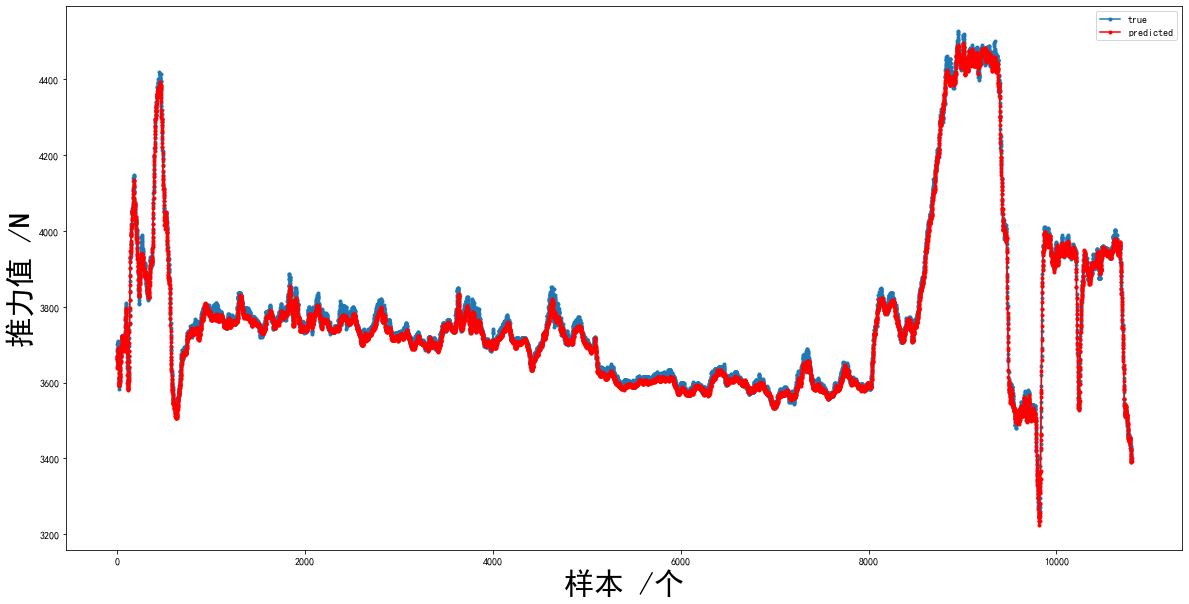

In [43]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot((predictions*19043.454262518393+23.9856747376088)[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend(); 